Pick and Place Study
====================
This is a simple notebook to test the accuracy and precision of the pick and place tooling/software being used in FPIX module assembly.

the procedure to acquire the data is the following:
  1. **Manually place an HDI on a pre-calibrated slot.** This is important simply because it gives the vision system a place to initially find the HDI.
  2. **Use the camera system to locate the center/orientation of the HDI.** Output this data to the log.
  3. **Acquire the `Picker` tool from the tool rack.**
  4. **Bring the picker tool over the center of the module.**
  5. **Rotate to match the module's rotation. (found in step 2)**
  6. **Bring the suction cups on the `Picker` tool in contact with the surface of the HDI.**
  7. **Turn on vacuum to the suction cups, wait .5s.**
  8. **Release vacuum to the chuck, wait .5s.**
  9. **Raise the `Picker` tool 5mm, bringing the HDI with it.**
  10. **Rotate the `Picker` tool back to 0.**
  11. **Bring gantry to the chuck's "Home" position**
  12. **Position the `Picker` tool over the "target position"\*. **
  13. **Rotate the `Picker` tool to match the target rotation.**
  14. **Bring HDI in contact with surface of chuck.**
  15. **Turn on chuck vacuum, wait .5s.**
  16. **Turn off suction cup vacuum, wait .5s.**
  17. **Raise `Picker` tool 5mm**
  18. **Rotate the `Picker` tool back to 0.**
  19. **Return `Picker` tool to the tool rack.**
  20. **Go back to step 2.**
  
  
\*The target position is shifted 1mm in x and y with respect to the initial position so the HDI doesn't catch the edges of the stencil.

In [1]:
import matplotlib
%matplotlib notebook
from matplotlib import rc
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
plt.style.use('fivethirtyeight')
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

In [2]:
data = [631.503,550.120,63.039,-0.086,
632.534,551.128,63.054,-0.026,
632.525,551.135,63.029,-0.026,
632.519,551.135,63.018,-0.029,
632.531,551.126,63.041,-0.026,
632.529,551.128,63.021,-0.028,
632.530,551.131,63.021,-0.029,
632.539,551.126,63.028,-0.030,
632.529,551.130,63.015,-0.031,
632.529,551.125,63.018,-0.030,
632.527,551.133,63.011,-0.032,
632.533,551.124,63.013,-0.032,
632.517,551.136,63.003,-0.031,
632.541,551.120,63.010,-0.035,
632.537,551.130,63.017,-0.033,
632.539,551.124,63.017,-0.033,
632.529,551.129,63.039,-0.035,
632.539,551.125,63.013,-0.029,
632.520,551.137,63.012,-0.033,
632.532,551.134,62.986,-0.034,
632.523,551.131,63.003,-0.033,
632.531,551.127,63.000,-0.034,
632.520,551.134,63.022,-0.037,
632.524,551.133,63.013,-0.034,
632.530,551.130,62.995,-0.035,
632.525,551.134,63.010,-0.035,
632.527,551.128,62.997,-0.035,
632.527,551.131,63.033,-0.035,
632.524,551.129,63.013,-0.032,
632.521,551.123,62.993,-0.046,
632.527,551.138,63.017,-0.026,
632.535,551.131,63.017,-0.034,
632.528,551.127,63.016,-0.034,
632.519,551.129,63.008,-0.043,
632.523,551.131,63.025,-0.040,
632.545,551.133,63.037,-0.023,
632.527,551.129,63.018,-0.032,
632.525,551.133,63.015,-0.037,
632.515,551.138,63.012,-0.036,
632.525,551.131,63.012,-0.036,
632.539,551.126,63.031,-0.036,
632.525,551.136,63.005,-0.033,
632.528,551.128,63.008,-0.036,
632.532,551.130,63.018,-0.036,
632.520,551.133,63.034,-0.036,
632.526,551.133,63.037,-0.032,
632.530,551.128,63.015,-0.030,
632.537,551.132,63.012,-0.040,
632.534,551.131,63.009,-0.036,
632.525,551.135,62.991,-0.037,
632.524,551.129,63.040,-0.036,
632.536,551.129,63.018,-0.035,
632.533,551.128,63.016,-0.037,
632.527,551.130,63.012,-0.036,
632.529,551.130,63.012,-0.038]

class Observation:
    def __init__(self, i, x, y, z , t):
        self.i = i
        self.x = x*1000
        self.y = y*1000
        self.z = z*1000
        self.t = t
    def __repr__(self):
        fmt = ("Observation {}:\n\tx={:7.3f}\n\ty={:7.3f}"
               "\n\tz={:7.3f}\n\tt={:+7.3f}\n")
        return fmt.format(self.i, self.x, self.y, self.z, self.t)
        
obs = [Observation(i, *data[i*4:(i+1)*4]) for i in range(len(data)//4)]
obs.pop(0) # Drop first observation because it isn't translated like the rest


def net_phi(*quat):
    from Quaternion import Quat
    quat = [float(q) for q in quat]
    quat = Quat(quat)
    v = np.array([1,0,0])
    v = quat.transform @ v
    return np.arctan2(v[1],v[0]) * 180/np.pi

target = Observation(0,632.521120,551.126947,63.003312, net_phi(0.000000,-0.000000,0.000662,-1.000000))

<IPython.core.display.Javascript object>


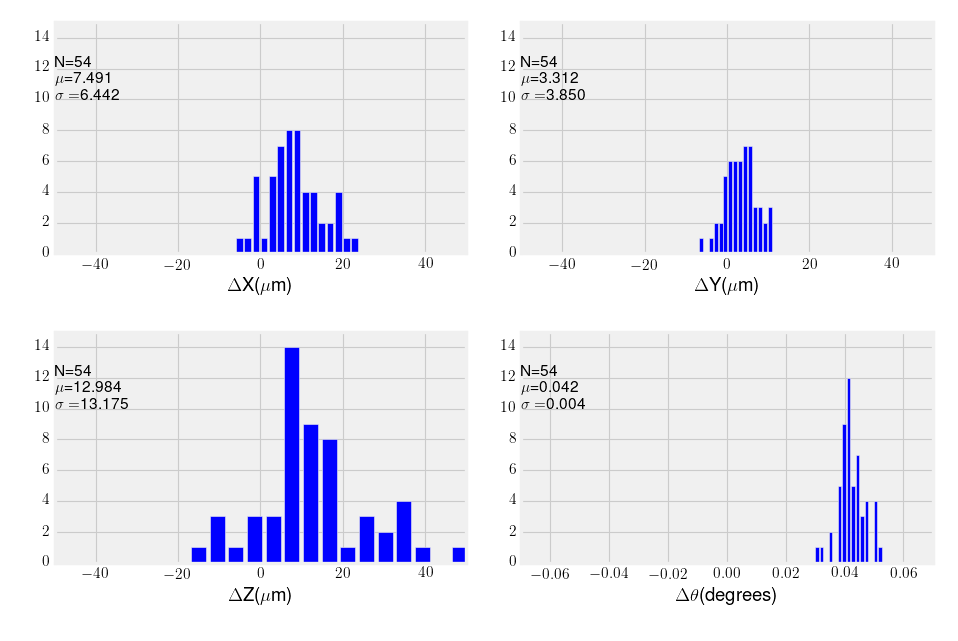

In [3]:
fig, axs = plt.subplots(nrows=2, ncols=2)

def histo(data, ax, xlabel, xlim=None, ymax=None):
        
    hist, bins = np.histogram(data, bins=15)
    width = 0.8 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    ax.bar(center, hist, align='center', width=width)
    ax.set_xlabel(xlabel)
    if xlim is None:
        xlim = (bins[0], bins[-1])
    ax.set_xlim(xlim)
    if ymax is not None:
        ax.set_ylim((0,ymax))
        
    fmt = "N={}\n$\mu$={:.3f}\n$\sigma=${:.3f}"
    label = fmt.format(len(data), np.mean(data), np.std(data))
    ax.text(xlim[0], 10, label)

xs, ys, zs, ts = zip(*[(ob.x-target.x, 
                        ob.y-target.y,
                        ob.z-target.z,
                        ob.t-target.t) for ob in obs])
histo(xs, axs[0][0], r'$\Delta$X($\mu$m)', (-50,50), 15)
histo(ys, axs[0][1], r'$\Delta$Y($\mu$m)', (-50,50), 15)
histo(zs, axs[1][0], r'$\Delta$Z($\mu$m)', (-50,50), 15)
histo(ts, axs[1][1], r'$\Delta\theta$(degrees)', (-.07, .07), 15)
plt.tight_layout()

<IPython.core.display.Javascript object>


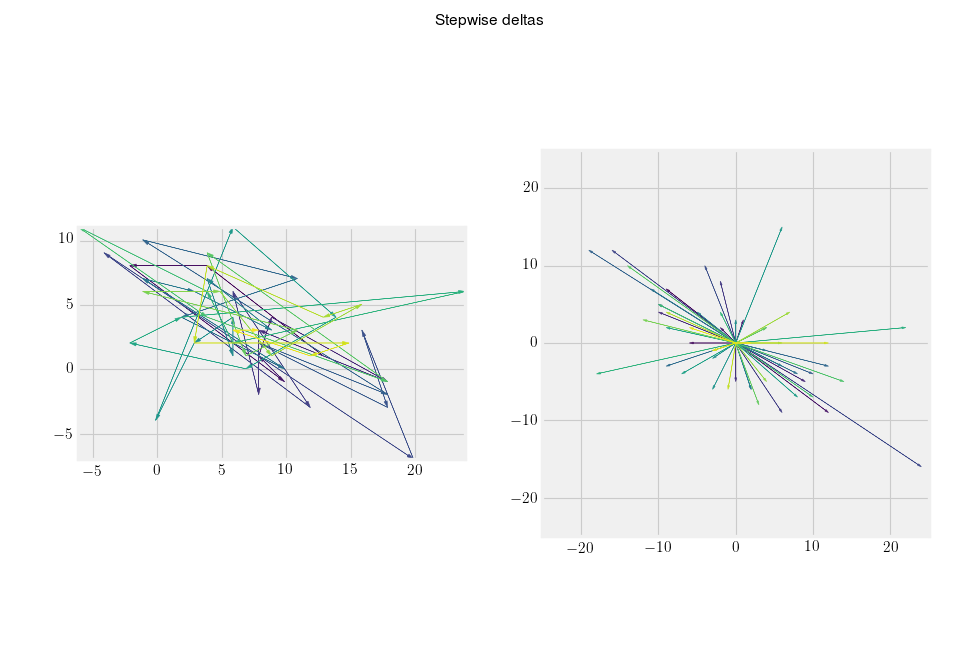

In [4]:
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_aspect(1)
ax2.set_aspect(1)
cmap = cm.get_cmap('viridis')

for ob1, ob2 in zip(obs[:-1],obs[1:]):
    color = cmap(ob1.i/len(obs))
    ax1.arrow(ob1.x-target.x, ob1.y-target.y,
              ob2.x-ob1.x, ob2.y-ob1.y,
              head_width=0.25, head_length=.5, fc=color, ec=color,
              length_includes_head=True)
    ax2.arrow(0, 0,
              ob2.x-ob1.x, ob2.y-ob1.y,
              head_width=0.25, head_length=.5, fc=color, ec=color,
              length_includes_head=True)
    
ax1.set_xlim((min(xs), max(xs)))
ax1.set_ylim((min(ys), max(ys)))
ax2.set_xlim((-25,25))
ax2.set_ylim((-25,25))
fig.suptitle("Stepwise deltas")